# Modelo #1 Red Neuronal Recurrente Univariada

In [1]:
## Uso general 
import pandas as pd
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import pickle

# Construcción de modelos
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor


C:\Users\andre\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


KeyboardInterrupt: 

In [ ]:
# Semilla para poder obtener resultados reproducibles
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

## Carga de datos

In [29]:
df = pd.read_csv("HistoricalQuotes.csv")
df.head()

,date,close,volume,open,high,low
0,2019/03/14,19.95,73578.0,20.14,20.180,19.90
1,2019/03/13,20.10,103553.0,20.30,20.330,19.99
2,2019/03/12,20.37,101823.0,20.79,20.905,20.34
3,2019/03/11,20.89,74490.0,21.03,21.100,20.71
4,2019/03/08,20.99,137966.0,20.41,21.100,20.41


In [30]:
# Ordeno el dataframe por fecha
df = df.sort_values(by=['date'],ascending=True)
df = df.reset_index(drop=True)
df.head()

,date,close,volume,open,high,low
0,2009/03/16,1.51,66174.0,1.50,1.53,1.500
1,2009/03/17,1.51,35448.0,1.68,1.68,1.490
2,2009/03/18,1.49,26360.0,1.50,1.53,1.490
3,2009/03/19,1.41,189240.0,1.43,1.48,1.365
4,2009/03/20,1.45,76175.0,1.41,1.47,1.400


C:\Users\andre\Anaconda3\lib\site-packages\pandas\core\series.py:3727: FutureWarning: from_csv is deprecated. Please use read_csv(...) instead. Note that some of the default arguments are different, so please refer to the documentation for from_csv when changing your function calls
  infer_datetime_format=infer_datetime_format)


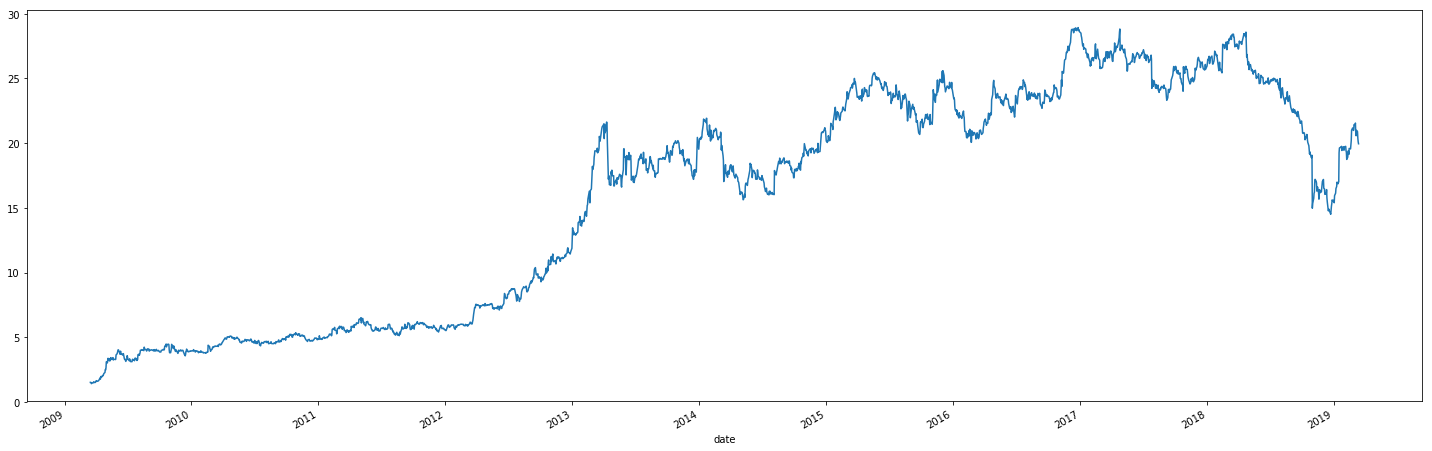

In [31]:
from pandas import Series
figure(num=None, figsize=(25,8), facecolor='w', edgecolor='b')
series = Series.from_csv('HistoricalQuotes.csv', header=0)
series.plot()

In [32]:
# descarto la existencia de nulos
df.isnull().sum()

date      0
close     0
volume    0
open      0
high      0
low       0
dtype: int64

### Pre procesamiento de los datos

In [33]:
# En esta red rnn solo vamos a utilizar la variable precio de cierre 
precio_cierre = df["close"].values.reshape(-1,1)
precio_cierre[0:5]

array([[1.51],
       [1.51],
       [1.49],
       [1.41],
       [1.45]])

In [34]:
# creo mi objeto para normalizar mis datos de entrada

sc = MinMaxScaler(feature_range = (0, 1))

In [35]:
precio_cierre_normalizado = sc.fit_transform(precio_cierre)

In [36]:
# Nro de días a predecir...
time_to_predict = 60

### Train/test

In [37]:
# todos los datos excepto los que voy a predecir 
data_train = precio_cierre_normalizado[0:-time_to_predict]

# datos que voy a predecir
data_test = precio_cierre_normalizado[-time_to_predict:len(precio_cierre_normalizado)]

print("Total de datos",precio_cierre_normalizado.shape)
print("Datos de entrenamiento: ",data_train.shape)
print("Datos de prueba: ",data_test.shape)

Total de datos (2517, 1)
Datos de entrenamiento:  (2457, 1)
Datos de prueba:  (60, 1)


### Creación estructura de los datos

In [38]:
X_train = []
y_train = []

retardos = 100

# construcción de la estructura para rnn de los datos

for i in range(retardos, len(data_train)):
    X_train.append(data_train[i-retardos:i, 0])
    y_train.append(data_train[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# añado una nueva dimensión a mis datos de entrenamiento, y cómo en este caso solo tengo
# uno solo predictor entonces pongo uno al final, [samples, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [39]:
def crear_estructura(retardos):
    
    X_train = []
    y_train = []

    # construcción de la estructura para rnn de los datos

    for i in range(retardos, len(data_train)):
        X_train.append(data_train[i-retardos:i, 0])
        y_train.append(data_train[i, 0])
    
    return np.array(X_train), np.array(y_train)

In [40]:
# muestra de la creación de la estructura el último valor de la siguiente es el valor de y anterior
print(X_train[1][-5:],y_train[0])
print(X_train[2][-5:],y_train[1])

[[0.08139535]
 [0.08284884]
 [0.07957849]
 [0.08284884]
 [0.08648256]] 0.0864825581395349
[[0.08284884]
 [0.07957849]
 [0.08284884]
 [0.08648256]
 [0.09375   ]] 0.09375


### Creación de los datos de Test

In [41]:
# extraemos los datos necesarios del pasado para predecir, por ejm 
# si cogemos el 1 de enero necesitamos los n días de retardos anteriores a este y así sucesivamente...
inputs = precio_cierre_normalizado[(len(precio_cierre_normalizado) - len(data_test) - retardos):len(precio_cierre_normalizado)]

# vector columna para datos de prueba
inputs = inputs.reshape(-1,1)

X_test = []

# Como aquí solo necesitamos las entradas de nuestros test set solo son los días a predecir
for i in range(retardos, (retardos+(time_to_predict))):
    X_test.append(inputs[i-retardos:i, 0])

X_test = np.array(X_test)

# le añado una nueva dimensión a mi data test, y ya queda listo para simplemente meterlo al predict!
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Construcción de la Arquitectura de la RNN univariada

### Tuning de Retardos:

Se va buscar cuál es el número de parámetros más adecuado para la RNN univariada, los valores entre los que se van a buscar son: **[10,20,40,60,100]**

Suposición de Hiperparametros:

    * Capas ocultas      2 
    * Neuronas por capa  32 
    * Dropout            0.2
    * lr                 0.001
    * epochs             70 
    * batch              32

In [22]:
def tuning_retardos(nro_retardos):
    
    resultado_retardos = []
    
    for j in range(len(nro_retardos)):
        
        X_train = []
        y_train = []

        retardos = nro_retardos[j]

        # construcción de la estructura para rnn de los datos

        for i in range(retardos, len(data_train)):
            X_train.append(data_train[i-retardos:i, 0])
            y_train.append(data_train[i, 0])

        X_train, y_train = np.array(X_train), np.array(y_train)

        # añado una nueva dimensión a mis datos de entrenamiento, y cómo en este caso solo tengo
        # uno solo predictor entonces pongo uno al final, [samples, timesteps, features]
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        
        
        # extraemos los datos necesarios del pasado para predecir, por ejm 
        # si cogemos el 1 de enero necesitamos los n días de retardos anteriores a este y así sucesivamente...
        inputs = precio_cierre_normalizado[(len(precio_cierre_normalizado) - len(data_test) - retardos):len(precio_cierre_normalizado)]

        # vector columna para datos de prueba
        inputs = inputs.reshape(-1,1)

        X_test = []

        # Como aquí solo necesitamos las entradas de nuestros test set solo son los días a predecir
        for i in range(retardos, (retardos+(time_to_predict))):
            X_test.append(inputs[i-retardos:i, 0])

        X_test = np.array(X_test)

        # le añado una nueva dimensión a mi data test, y ya queda listo para simplemente meterlo al predict!
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        
        
        #######################################################################################################################################
        
        
        rnn_univariate = Sequential()                                                                             
                                                                                            # Retardos   Predictores
        rnn_univariate.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        rnn_univariate.add(Dropout(0.2))       
            
        rnn_univariate.add(LSTM(units = 32, return_sequences = True))
        rnn_univariate.add(Dropout(0.2))

        rnn_univariate.add(LSTM(units = 32))
        rnn_univariate.add(Dropout(0.2))
        
        rnn_univariate.add(Dense(units = 1))

        # se dejan los valores sugeridos en la documentación de keras,y en otros Frameworks 
        # también se tiene exactamente la misma configuración inicial
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        rnn_univariate.compile(optimizer = adam, loss = 'mean_squared_error')

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        
        # entrenamiento
        history = rnn_univariate.fit(X_train, y_train, epochs = 70,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)
        
        # predigo los datos de entrada de prueba
        predicted_stock_price = rnn_univariate.predict(X_test)
        
        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        resultado_retardos.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                  len(rnn_univariate.history.history['loss']),
                                  r2_score(real_stock_price,predicted_stock_price)
                                  ])
        
        
    return resultado_retardos

nro_retardos = [10,20,40,60,100]

resultado_tuning_retardos = tuning_retardos(nro_retardos)
         

Train on 1957 samples, validate on 490 samples
Epoch 1/70
1957/1957 [==============================] - 4s 2ms/step - loss: 0.0374 - val_loss: 0.0038
Epoch 2/70
1957/1957 [==============================] - 1s 450us/step - loss: 0.0055 - val_loss: 0.0019
Epoch 3/70
1957/1957 [==============================] - 1s 411us/step - loss: 0.0048 - val_loss: 6.7574e-04
Epoch 4/70
1957/1957 [==============================] - 1s 448us/step - loss: 0.0041 - val_loss: 0.0013
Epoch 5/70
1957/1957 [==============================] - 1s 454us/step - loss: 0.0037 - val_loss: 9.2064e-04
Epoch 6/70
1957/1957 [==============================] - 1s 417us/step - loss: 0.0036 - val_loss: 0.0019
Epoch 7/70
1957/1957 [==============================] - 1s 412us/step - loss: 0.0034 - val_loss: 0.0011
Epoch 8/70
1957/1957 [==============================] - 1s 385us/step - loss: 0.0031 - val_loss: 0.0010
Epoch 9/70
1957/1957 [==============================] - 1s 408us/step - loss: 0.0033 - val_loss: 9.3222e-04
Epoch 1

Epoch 26/70
1949/1949 [==============================] - 1s 729us/step - loss: 0.0022 - val_loss: 8.0798e-04
Epoch 27/70
1949/1949 [==============================] - 1s 691us/step - loss: 0.0022 - val_loss: 0.0032
Epoch 28/70
1949/1949 [==============================] - 1s 710us/step - loss: 0.0024 - val_loss: 8.3757e-04

Epoch 00028: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 29/70
1949/1949 [==============================] - 1s 724us/step - loss: 0.0020 - val_loss: 8.1368e-04
Epoch 30/70
1949/1949 [==============================] - 2s 807us/step - loss: 0.0020 - val_loss: 0.0011
Epoch 31/70
1949/1949 [==============================] - 1s 722us/step - loss: 0.0022 - val_loss: 8.0451e-04
Epoch 32/70
1949/1949 [==============================] - 1s 743us/step - loss: 0.0020 - val_loss: 9.2781e-04
Epoch 33/70
1949/1949 [==============================] - 1s 714us/step - loss: 0.0019 - val_loss: 0.0010
Epoch 34/70
1949/1949 [==============================] - 1s

Epoch 14/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0028 - val_loss: 9.0211e-04
Epoch 15/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0028 - val_loss: 9.1558e-04
Epoch 16/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0028 - val_loss: 0.0037
Epoch 17/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0031 - val_loss: 9.3051e-04
Epoch 18/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 19/70
1917/1917 [==============================] - 4s 2ms/step - loss: 0.0032 - val_loss: 8.3978e-04

Epoch 00019: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 00019: early stopping
Train on 1885 samples, validate on 472 samples
Epoch 1/70
1885/1885 [==============================] - 10s 5ms/step - loss: 0.0397 - val_loss: 0.0014
Epoch 2/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch

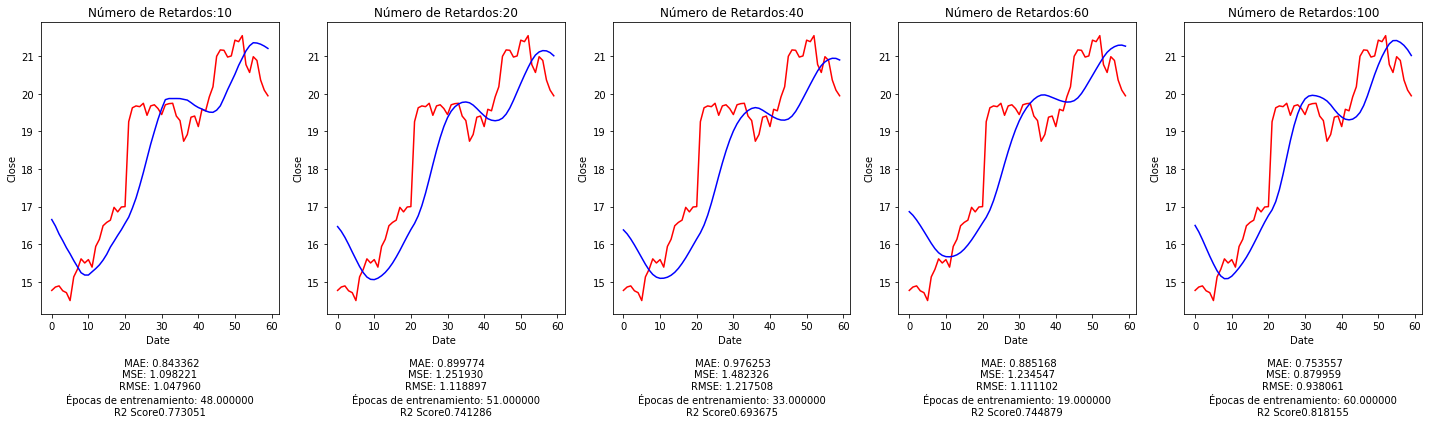

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=5,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de retardos:"+str(nro_retardos[count])) 
        
    ax.plot(resultado_tuning_retardos[count][1],color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_tuning_retardos[count][0],color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_tuning_retardos[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_tuning_retardos[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(resultado_tuning_retardos[count][4])) 
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Retardos:'+str(nro_retardos[count])))

    fig    
    plt.tight_layout()
    
    count+=1



**Resultado tuning de retardos:**

*Retardos: 100*

*Obtuvo Menor error en las 3 métricas de error (MAE,MSE,RMSE) y  mayor R2 Score (0.818)*

___

## Tuning Capas

Luego de conocer cual es el número de retardos más adecuado, se procede a buscar cuál es el número de capas ocultas con mejor rendimiento

Se van a suponer los siguientes hiperparámetros 

    * LSTM       50 
    * dropout    0.2
    * lr         0.001
    * patience   5
    * batch size 32
    * epochs     70

In [43]:
def grid_layers(layers):
    
    resultado_capas = []
    
    for i in range(len(layers)):        
        
        rnn_univariate = Sequential()                                                                             
                                                                                    # Retardos   Predictores
        rnn_univariate.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
        rnn_univariate.add(Dropout(0.2))
        
        for j in range(layers[i]-1):
            
            rnn_univariate.add(LSTM(units = 32, return_sequences = True))
            rnn_univariate.add(Dropout(0.2))
            
        rnn_univariate.add(LSTM(units = 32))
        rnn_univariate.add(Dropout(0.2))
        
        rnn_univariate.add(Dense(units = 1))

        # se dejan los valores sugeridos por la literatura, son los más recomendados y en otros Frameworks también se tiene exactamente la misma 
        # configuración inicial
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        rnn_univariate.compile(optimizer = adam, loss = 'mean_squared_error')

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        # entrenamiento
        history = rnn_univariate.fit(X_train, y_train, epochs = 70,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)
        
        # predigo los datos de entrada de prueba
        predicted_stock_price = rnn_univariate.predict(X_test)
        
        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        resultado_capas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(rnn_univariate.history.history['loss'])
                               ])
    
    return resultado_capas

layers = [2,4,8,16]
resultado_arquitectura_capas = grid_layers(layers)
    

Train on 1885 samples, validate on 472 samples
Epoch 1/70
1885/1885 [==============================] - 11s 6ms/step - loss: 0.0436 - val_loss: 0.0025
Epoch 2/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 3/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 0.0023
Epoch 4/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 0.0013
Epoch 5/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0044 - val_loss: 0.0019
Epoch 6/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 7/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0042 - val_loss: 0.0015
Epoch 8/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0040 - val_loss: 0.0011
Epoch 9/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 10/70
1885/1885 [===========

1885/1885 [==============================] - 39s 21ms/step - loss: 0.0045 - val_loss: 0.0128
Epoch 24/70
1885/1885 [==============================] - 39s 21ms/step - loss: 0.0044 - val_loss: 0.0131
Epoch 25/70
1885/1885 [==============================] - 39s 21ms/step - loss: 0.0044 - val_loss: 0.0121
Epoch 26/70
1885/1885 [==============================] - 42s 22ms/step - loss: 0.0049 - val_loss: 0.0091
Epoch 27/70
1885/1885 [==============================] - 43s 23ms/step - loss: 0.0045 - val_loss: 0.0116
Epoch 28/70
1885/1885 [==============================] - 41s 22ms/step - loss: 0.0041 - val_loss: 0.0113
Epoch 29/70
1885/1885 [==============================] - 41s 21ms/step - loss: 0.0042 - val_loss: 0.0117
Epoch 30/70
1885/1885 [==============================] - 41s 22ms/step - loss: 0.0042 - val_loss: 0.0141
Epoch 31/70
1885/1885 [==============================] - 40s 21ms/step - loss: 0.0043 - val_loss: 0.0098
Epoch 32/70
1885/1885 [==============================] - 40s 21ms/s

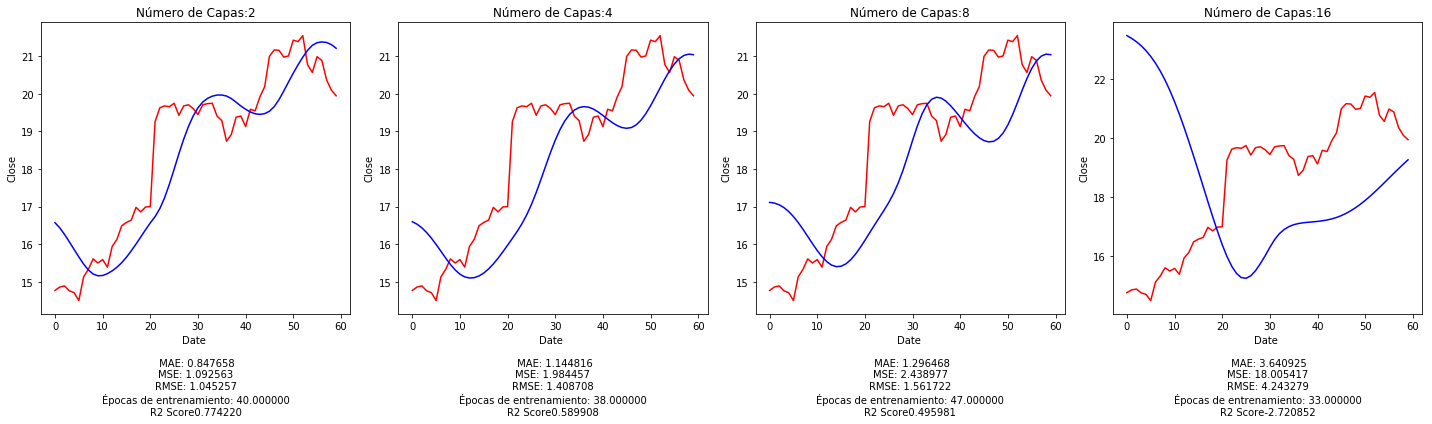

In [46]:
fig, axes = plt.subplots(nrows=1, ncols=4,figsize=(20,6))

count = 0
for ax in axes:    
        
    titulo = str("Número de capas:"+str(layers[count]))     

    ax.plot(resultado_arquitectura_capas[count][1],color = 'red',label = 'Real S&P Stock Price')
    ax.plot(resultado_arquitectura_capas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')
    
    ax.set_xlabel('Date \n'+
                  str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][0]))+'\n'+
                  str('MSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][1]))+'\n'+
                  str('RMSE: ' + '{:f}'.format(resultado_arquitectura_capas[count][2][2]))+'\n'+
                  str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_capas[count][3]))+'\n'+
                  str('R2 Score' + '{:f}'.format(r2_score(resultado_arquitectura_capas[count][1],resultado_arquitectura_capas[count][0])))  
        
                 )
    ax.set_ylabel('Close')
    ax.set_title(str('Número de Capas:'+str(layers[count])))

    fig    
    plt.tight_layout()
    
    count+=1

**Resultado tuning capas ocultas:**

Se seleccionan **2 capas ocultas**, menor error en las 3 métricas de error y mayor R2

---


### Tunning neuronas

Se va a seleccionar el número de unidades LSTM en nuestra red

Se supone los siguientes hiperparámetros :
    
    * Layers     2
    * retardos   100
    * dropout    0.2
    * lr         0.001
    * batch size 32
    * epochs     70

In [47]:
def grid_neurons(neuronas):
    
    resultado_neuronas = []
    
    for i in range(len(neuronas)):
        
        rnn_univariate = Sequential()                                                                             
                                                                                    # Retardos   Predictores
        rnn_univariate.add(LSTM(units = neuronas[i], return_sequences = True, input_shape = (X_train.shape[1], 1)))
        rnn_univariate.add(Dropout(0.2))       
            
        rnn_univariate.add(LSTM(units = neuronas[i], return_sequences = True))
        rnn_univariate.add(Dropout(0.2))

        rnn_univariate.add(LSTM(units = neuronas[i]))
        rnn_univariate.add(Dropout(0.2))
        
        rnn_univariate.add(Dense(units = 1))

        # se dejan los valores sugeridos por la literatura, son los más recomendados y en otros Frameworks también se tiene exactamente la misma 
        # configuración inicial
        adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

        rnn_univariate.compile(optimizer = adam, loss = 'mean_squared_error')

        es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
        rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
        # mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

        # entrenamiento
        history = rnn_univariate.fit(X_train, y_train, epochs = 70,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)
        
        # predigo los datos de entrada de prueba
        predicted_stock_price = rnn_univariate.predict(X_test)
        
        # aplico la transformación inversa para dejar los datos en la escala inicial
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        # precios reales
        real_stock_price = precio_cierre[-(time_to_predict):]
        
        resultado_neuronas.append([predicted_stock_price,
                               real_stock_price,
                               [metrics.mean_absolute_error(real_stock_price, predicted_stock_price),
                                metrics.mean_squared_error(real_stock_price, predicted_stock_price),
                                np.sqrt(metrics.mean_squared_error(real_stock_price, predicted_stock_price))],
                                len(rnn_univariate.history.history['loss']),
                                r2_score(real_stock_price,predicted_stock_price) 
                                  ])
    
    return resultado_neuronas

neuronas = [2,4,8,16,32,64]
resultado_arquitectura_neuronas = grid_neurons(neuronas)

Train on 1885 samples, validate on 472 samples
Epoch 1/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.1525 - val_loss: 0.2129
Epoch 2/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0739 - val_loss: 0.1198
Epoch 3/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0412 - val_loss: 0.0333
Epoch 4/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0305 - val_loss: 0.0276
Epoch 5/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0284 - val_loss: 0.0224
Epoch 6/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0263 - val_loss: 0.0193
Epoch 7/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0263 - val_loss: 0.0110
Epoch 8/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0216 - val_loss: 0.0086
Epoch 9/70
1885/1885 [==============================] - 5s 3ms/step - loss: 0.0223 - val_loss: 0.0100
Epoch 10/70
1885/1885 [===========

1885/1885 [==============================] - 6s 3ms/step - loss: 0.0057 - val_loss: 0.0018
Epoch 10/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0057 - val_loss: 0.0023
Epoch 11/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 12/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 13/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 14/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0049 - val_loss: 0.0015
Epoch 15/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0047 - val_loss: 0.0019
Epoch 16/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0045 - val_loss: 0.0023
Epoch 17/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0042 - val_loss: 0.0018
Epoch 18/70
1885/1885 [==============================] - 6s 3ms/step - loss: 0.0042 -

1885/1885 [==============================] - 7s 4ms/step - loss: 0.0022 - val_loss: 8.6413e-04
Epoch 29/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0023 - val_loss: 9.7747e-04
Epoch 30/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 31/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0022 - val_loss: 8.0103e-04
Epoch 32/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0022 - val_loss: 9.3032e-04
Epoch 33/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0023 - val_loss: 8.0824e-04

Epoch 00033: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 34/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0021 - val_loss: 8.6592e-04
Epoch 35/70
1885/1885 [==============================] - 7s 4ms/step - loss: 0.0022 - val_loss: 9.9536e-04
Epoch 36/70
1885/1885 [==============================] - 8s 4ms/step - loss: 0.

1885/1885 [==============================] - 13s 7ms/step - loss: 0.0013 - val_loss: 6.4148e-04
Epoch 39/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 6.5132e-04
Epoch 40/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0013 - val_loss: 9.2286e-04
Epoch 41/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 42/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0013 - val_loss: 0.0014

Epoch 00042: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 43/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 5.1884e-04
Epoch 44/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 5.2084e-04
Epoch 45/70
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0012 - val_loss: 5.4219e-04
Epoch 46/70
1885/1885 [==============================] - 13s 7ms/step - los

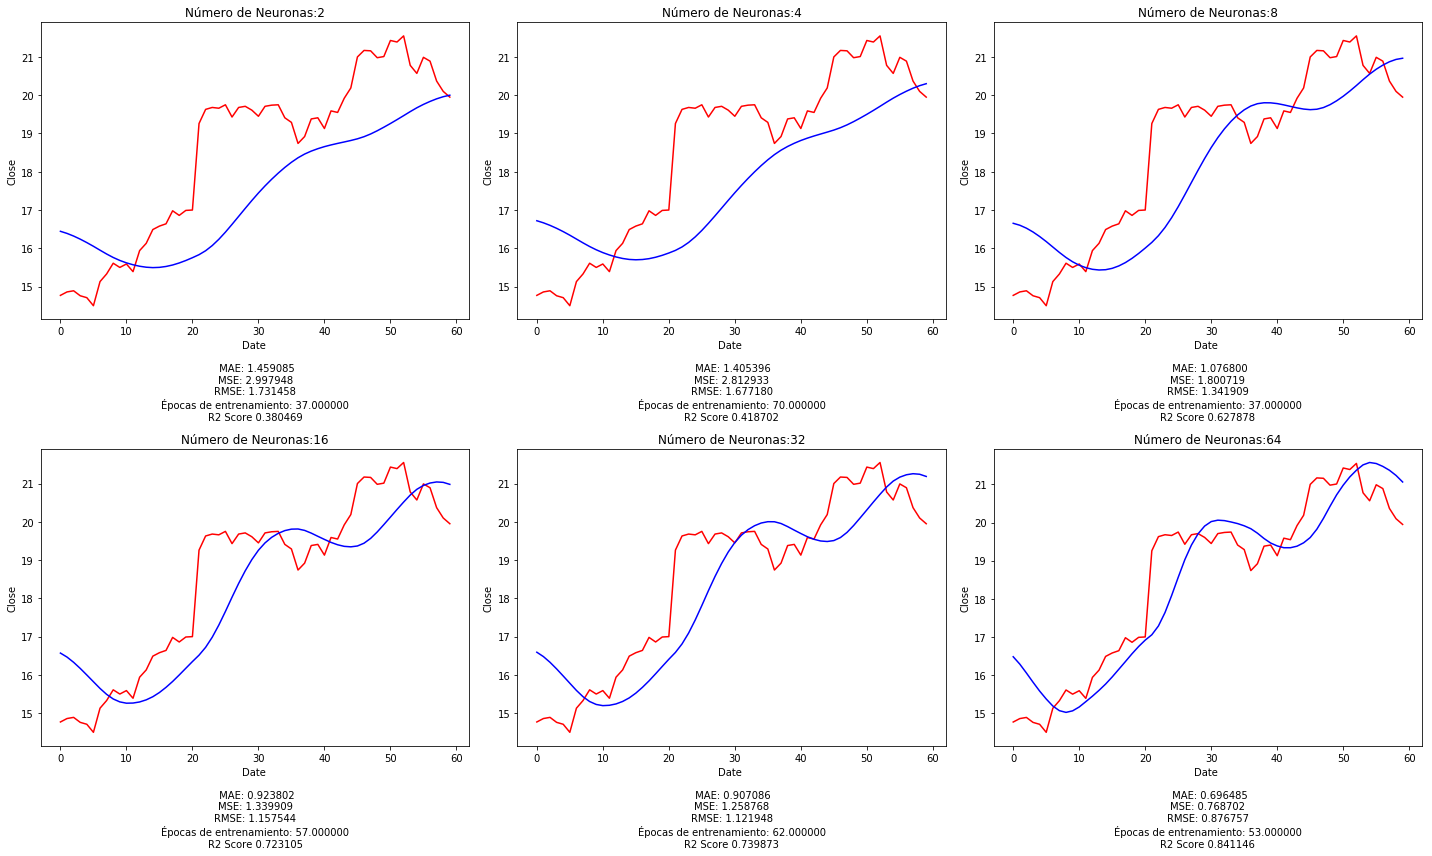

In [49]:
fig, axes = plt.subplots(nrows=2, ncols=3,figsize=(20,12))

count = 0
for fila in axes:
    for ax in fila:    

        titulo = str("Número de Neuronas:"+str(neuronas[count]))     

        ax.plot(resultado_arquitectura_neuronas[count][1],color = 'red',label = 'Real S&P Stock Price')
        ax.plot(resultado_arquitectura_neuronas[count][0],color = 'blue',label = 'Predicted S&P Stock Price')

        ax.set_xlabel('Date \n'+
                      str('\n MAE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][0]))+'\n'+
                      str('MSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][1]))+'\n'+
                      str('RMSE: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][2][2]))+'\n'+
                      str('Épocas de entrenamiento: ' + '{:f}'.format(resultado_arquitectura_neuronas[count][3]))+'\n'+
                      str('R2 Score ' + '{:f}'.format(resultado_arquitectura_neuronas[count][4]))  
                     )
        ax.set_ylabel('Close')
        ax.set_title(str('Número de Neuronas:'+str(neuronas[count])))

        fig    
        plt.tight_layout()

        count+=1
    

**Resultado tuning neruonas**

Se escoge 64 neuronas por capas, presentó el menor error en las 3 métricas y Mayor R2

### Grid Search 

Se procede a ajustar los hiperparámetros
 * Batchsize
 * epochs
 * dropout
 * lr
 * loss function

In [62]:
def grid_rnn(dropout,loss,lr):   
        
    rnn_univariate = Sequential()                                                                             
                                                                               # Retardos   Predictores
    rnn_univariate.add(LSTM(units = 32, return_sequences = True, input_shape = (X_train.shape[1], 1)))
    rnn_univariate.add(Dropout(dropout))       

    rnn_univariate.add(LSTM(units = 32, return_sequences = True))
    rnn_univariate.add(Dropout(dropout))
    
    rnn_univariate.add(LSTM(units = 32))
    rnn_univariate.add(Dropout(dropout))

    rnn_univariate.add(Dense(units = 1))

    adam = optimizers.Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

    rnn_univariate.compile(optimizer = adam, loss = loss )

    return  rnn_univariate


regresor = KerasRegressor(build_fn = grid_rnn)

parameters = {'batch_size': [32,64],
              'epochs': [50,70],
              'dropout':[0.2,0.3],
              'lr':[0.01,0.001],
              'loss':['mean_squared_logarithmic_error','mean_squared_error']
             }

grid_search = GridSearchCV(estimator = regresor,
                           param_grid = parameters,
                           cv=2
                           )
grid_search = grid_search.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
best_parameters = grid_search.best_params_
best_accuracy = grid_search.best_score_

# Modelo Final

Resultado grid:

    {'batch_size': 64,
     'dropout': 0.2,
     'epochs': 50,
     'loss': 'mean_squared_error',
     'lr': 0.01}
     


In [60]:
rnn_univariate = Sequential()
                                                                            # Retardos   Predictores
rnn_univariate.add(LSTM(units = 64, return_sequences = True, input_shape = (X_train.shape[1], 1)))
rnn_univariate.add(Dropout(0.2))

rnn_univariate.add(LSTM(units = 64, return_sequences = True))
rnn_univariate.add(Dropout(0.2))

rnn_univariate.add(LSTM(units = 64))
rnn_univariate.add(Dropout(0.2))

rnn_univariate.add(Dense(units = 1))

adam = optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=10e-8, decay=0.0)

rnn_univariate.compile(optimizer = adam, loss = 'mse')

es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=5, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=5, verbose=1)
# mcp = ModelCheckpoint(filepath='weights.h5', monitor='loss', verbose=1, save_best_only=True, save_weights_only=True)

# entrenamiento
history = rnn_univariate.fit(X_train, y_train, epochs = 50 ,callbacks=[es, rlr], batch_size = 32,validation_split=0.2)

Train on 1885 samples, validate on 472 samples
Epoch 1/50
1885/1885 [==============================] - 92s 49ms/step - loss: 0.1176 - val_loss: 0.0042
Epoch 2/50
1885/1885 [==============================] - 11s 6ms/step - loss: 0.0034 - val_loss: 0.0011
Epoch 3/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 4/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0032 - val_loss: 0.0014
Epoch 5/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 6/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 7/50
1885/1885 [==============================] - 13s 7ms/step - loss: 0.0023 - val_loss: 8.5059e-04
Epoch 8/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 9/50
1885/1885 [==============================] - 12s 6ms/step - loss: 0.0020 - val_loss: 9.0134e-04
Epoch 10/50
1885/

In [63]:
# predigo los datos de entrada de prueba
predicted_stock_price = rnn_univariate.predict(X_test)

# aplico la transformación inversa para dejar los datos en la escala inicial
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# precios reales
real_stock_price = precio_cierre[-(time_to_predict):]

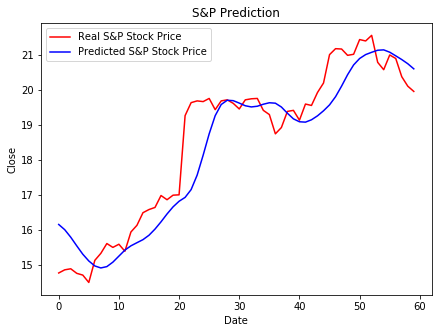

In [64]:
figure(figsize=(7,5))
plt.plot(real_stock_price, color = 'red', label = 'Real S&P Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted S&P Stock Price')
plt.title('S&P Prediction')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [65]:
from sklearn.metrics import r2_score
r2_score(real_stock_price,predicted_stock_price)

0.8649299026637531

In [66]:
#guardo el modelo en disco
rnn_univariate.save("rnn_univariate.h5") 

In [72]:
## escribo X_test para modelo 1 para luego leer los datos en el ensamble de modelo y no tener que reconstruirlo
with open('X_test_1.data', 'wb') as filehandle:  
    pickle.dump(X_test, filehandle)